# Rozdzielczość obrazu. Interpolacja.

## Cel zajęć:

* zapoznanie z pojęciem rozdzielczości przestrzennej (rozmiaru obrazu),
* metody interpolacji najbliższego sąsiada oraz dwuliniowa,
* zapoznanie z pojęciem rozdzielczości dpi (ang. dots per inch),
* zapoznanie z pojęciem rozdzielczości  poziomów jasności (dla obrazów w skali szarości),
* zadanie domowe: interpolacja dwusześcienna.

## Rodzielczość przestrzenna

Dyskretna reprezentacja obrazu to zwykle macierz dwu (N x M - obraz w skali szarości) lub trójwymiarowa (N x M x 3 - obraz kolorowy).
Przez rozdzielczość przestrzenną rozumie się liczbę pikseli z których składa się obraz.
Przykładowo rozdzielczość VGA to  640 x 480, Full HD to 1920 x 1080, a 4K to 3840 x 2160.
Rozdzielczość obrazu można modyfikować (zwiększać/zmniejszać), co nazywa się skalowaniem obrazu.
Warto wiedzieć, że zwiększenie rozdzielczości obrazu nie zwiększa ilości informacji, a jedynie liczbę pikseli (w sensie "lepiej nie będzie").
Ponadto skalowanie zawsze wprowadza pewne zniekształcenia, nawet przy zmniejszaniu rozmiaru.

W ramach niniejszego ćwiczenia zapoznamy się z metodami interpolacji, które są podstawą takich operacji jak: przybliżanie (zoom), zmiana rozdzielczości, rotacja obrazu, czy też korekcje geometryczne.
Jako przykład posłuży nam zmiana rozdzielczości, czyli inaczej mówiąc przepróbkowanie obrazu.
Dla przypomnienia - interpolacja to wykorzystanie znanych danych (wartości dla tzw. punktów węzłowych) do określania wartości w nieznanych lokalizacjach.

Zacznijmy od prostego przykładu.
Mamy obraz o rozdzielczości 500 x 500 pikseli, a chcemy go powiększyć do 750 x 750 pikseli -- tj. o~współczynnik 1,5.
Wyobraźmy sobie zatem, że dysponujemy siatką 750 x 750 o takim samym "rozmiarze" pojedynczego piksela jak obraz oryginalny.
Następnie siatkę tą ,,ścieśniamy'', tak aby miała rozmiar 500 x 500.
W rezultacie otrzymana siatka będzie miała mniejszy rozmiar pojedynczego piksela niż obraz oryginalny.
Schematycznie przedstawiono to na poniższym rysunku.

![Ilustracja interpolacji](https://raw.githubusercontent.com/vision-agh/poc_sw/master/05_Resolution/img/interEx57.png)


Pokazuje on przykład interpolacji: a) obraz 5x5, b) oraz 7x7, c) obraz 7x7 zmiejszony do 5x5.


Chcemy teraz poszczególnym elementom nowej siatki przyporządkować piksele z obrazu wejściowego.
Jedną z możliwości jest poszukanie "najbliższego" piksela w oryginalnym obrazie i wzięcie jego wartości.
Przykład takiego postępowania zaprezentowano na  poniższym rysunku.

![Ilustracja najbliższego sąsiada](https://raw.githubusercontent.com/vision-agh/poc_sw/master/05_Resolution/img/inteNNEx.png)

Kilka słów wyjasnienia.
Kolorem ciemnoszarym oznaczono siatkę 5x5, a czarnym 7x7 (już po przeskalowaniu).
Nasze zadanie sprowadza się do zalezienia dla każdej kropki czarnej (umowny środek piksela), najbliżej leżącej kropki szarej - oznaczono to dla pierwszych trzech wierzszy obrazu liniami.

Po zrealizowaniu powyższego kroku dla całego obrazu wykonujemy "rozciągniecie" do rozdzielczości 750 x 750.
W ten sposób uzyskujemy finalny efekt zmiany rozdzielczości.

## Interpolacja metodą najbliższego sąsiada

Takie postępowanie określa się mianem **interpolacji metodą najbliższego sąsiada** (ang. *nearest neighbour interpolation*).
W ramach pierwszego etapu ćwiczenia zaimplementujemy to podejście.

1. Ładujemy potrzebne biblioteki, pobieramy obrazy z repozytorium, wczytujemy jeden z obrazów testowych (*parrot.bmp*) i wyświetlamy go:

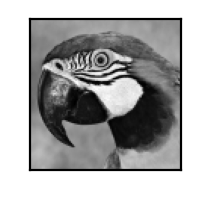

In [2]:
import cv2
import os
from matplotlib import pyplot as plt
import numpy as np

# Load required files
if not os.path.exists("parrot.bmp") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/05_Resolution/parrot.bmp --no-check-certificate
if not os.path.exists("clock.bmp") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/05_Resolution/clock.bmp --no-check-certificate
if not os.path.exists("chessboard.bmp") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/05_Resolution/chessboard.bmp --no-check-certificate
if not os.path.exists("lena.bmp") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/05_Resolution/lena.bmp --no-check-certificate
if not os.path.exists("firetruck.jpg") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/05_Resolution/firetruck.jpg --no-check-certificate


I = cv2.imread('parrot.bmp')           # Read image
I = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY) # Convert to RGB

# Display
plt.figure(figsize=(I.shape[0]/100,I.shape[1]/100), dpi=200)
plt.imshow(I, cmap ="gray")
plt.xticks([]), plt.yticks([])  # Hides the graph ticks and x / y axis
plt.show()

2. Definiujemy funkcję do interpolacji metodą najbliższego sąsiada.

Jako argumenty wejściowe powinna ona przyjąć obraz oraz współczynniki skalowania w pionie i poziomie.
Wyjściem powinien być natomiast obraz w nowej rozdzielczości.
Wewnątrz należy:

* odczytać wymiary obrazka wejściowego,
* wyliczyć wymiary obrazka wyjściowego (tj. wymnożyć wymiary wejściowe przez skalę i zaokrąglić do liczb całkowitych),
* utworzyć nowy obraz o ww. rozmiarze,
* w pętli po nowym obrazie, dla każdego piksela, wykorzystując współczynniki skalowania, odnaleźć najbliższego sąsiada.




In [51]:
def interpolacja_najblizszy_sasiad(IMG, skala_X, skala_Y):
    X, Y = IMG.shape
    new_X = int(X*skala_Y)
    new_Y = int(Y*skala_X)
    new_IMG = np.zeros([new_X, new_Y])
    
    for i in range(0, new_X):
        for j in range(0, new_Y):
            x_i = round(i/skala_Y)
            y_j = round(j/skala_X)
            
            if x_i >= X:
                x_i = x_i - 1
            if y_j >= Y:
                y_j = y_j - 1

            new_IMG[i,j] = IMG[x_i, y_j]
            
    return new_IMG


3. Testujemy stworzoną funkcję:
    * dla skali 1.5, 1.5 i obrazka *parrot*,
    * dla 2.5, 2.5 - tu okaże się, że do kodu trzeba dopisać zabezpieczenie przed wyjściem poza zakres,
    * dla niejednakowych skal np. 1.5 i 2.5,
    * dla skal mniejszych od 1,
    * dla niesymetrycznego obrazka *clock*,
    * dla obrazka z szachownicą *chessboard*.

Uwaga: proszę dla powyższych przypadków przygotować osobne sekcje kodu - tak, aby wyświetlały się wszystkie rozważane przypadki.

Wykonana metoda jest bardzo prosta i szybka, ale wprowadza pewne niepożądane artefakty, w szczególnie źle odwzorowane są linie proste.
Z drugiej strony sprawdza się w pewnych nietypowych przypadkach.
Zostanie to zademonstrowane w dalszej części ćwiczenia.

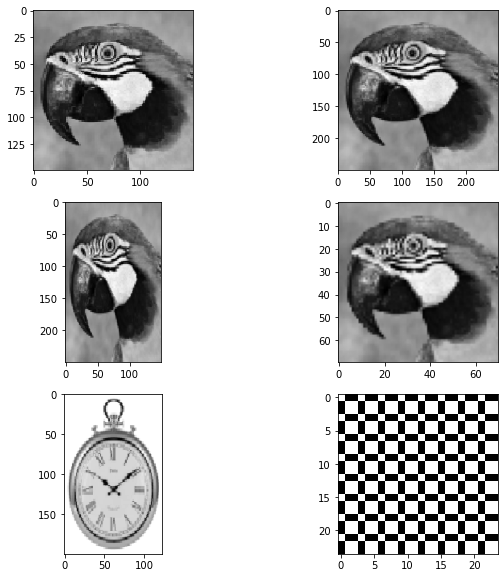

In [59]:
# TODO: Do samodzielnej implemetantacji
fig_parrot, ([ax1, bx1], [ax2, bx2], [cx1, cx2]) = plt.subplots(3,2, figsize=(10,10))

CLOCK = cv2.imread('clock.bmp')           
CLOCK = cv2.cvtColor(CLOCK, cv2.COLOR_BGR2GRAY)

CHESS = cv2.imread('chessboard.bmp')           
CHESS = cv2.cvtColor(CHESS, cv2.COLOR_BGR2GRAY)
plt.gray()

ax1.imshow(interpolacja_najblizszy_sasiad(I, 1.5, 1.5))
bx1.imshow(interpolacja_najblizszy_sasiad(I, 2.5, 2.5))
ax2.imshow(interpolacja_najblizszy_sasiad(I, 1.5, 2.5))
bx2.imshow(interpolacja_najblizszy_sasiad(I, 0.7, 0.7))
cx1.imshow(interpolacja_najblizszy_sasiad(CLOCK, 1.5, 2))
cx2.imshow(interpolacja_najblizszy_sasiad(CHESS, 1.5, 1.5))


## Interpolacja dwuliniowa

W praktyce, lepszym rozwiązaniem zwykle okazuje tzw. **interpolacja dwuliniowa** (ang. *bilinear interpolation*).
Wykorzystuje ona informację o czterech najbliższych sąsiadach do określenia nowej wartości piksela.

Jeśli przez $(i,j)$ oznaczymy współrzędne poszukiwanego piksela, a przez $I(i,j)$ jego jasność (składową w~odcieniach szarości) to jego wartość można obliczyć wykorzystując równanie:
\begin{equation}
I(i,j) = a \cdot i + b \cdot j+ c \cdot i \cdot j + d
\end{equation}
gdzie: współczynniki $a,b,c,d$ można wyliczyć na podstawie czterech najbliższych sąsiadów.

![Ilustracja dwuliniowej](https://raw.githubusercontent.com/vision-agh/poc_sw/master/05_Resolution/img/interABCD.png)

Prześledźmy to na przykładzie z powyższego rysunku.
Niech współrzędne poszczególnych punktów to $A = (j_1,i_1)$, $B = (j_1,i_2)$, $ C= (j_2,i_2)$ oraz $D = (j_2,i_1)$.
W pierwszej kolejności dokonujemy interpolacji wartości w punktach $AB$ i $CD$ -- czyli poziomo.
Wychodząc od równania prostej otrzymujemy:

\begin{equation}
f(AB) \approx \frac{i_2 - i}{i_2-i_1}f(A) + \frac{i - i_1}{i_2-i_1}f(B)
\end{equation}

\begin{equation}
f(CD) \approx \frac{i_2 - i}{i_2-i_1}f(D) + \frac{i - i_1}{i_2-i_1}f(C)
\end{equation}

Następnie wykonujemy analogiczną interpolację w pionie:
\begin{equation}
f(ABCD) \approx \frac{j_2 - j}{j_2-j_1}f(AB) + \frac{j - j_1}{j_2-j_1}f(CD)
\end{equation}

Łącząc powyższe równania otrzymujemy:
\begin{equation}
f(ABCD) \approx \frac{1}{(i_2 - i_1)(j_2-j_1)} ( f(A)(i_2-i)(j_2 - y) + f(B)(i-i_1)(j_2 - j) \\ + f(C)(i-i_1)(j-j_1) + f(D)(i_2-i)(j-j_1))
\end{equation}
gdzie zapis $f(X)$ oznacza wartość piksela w punkcie $X$.

Rozważania można uprościć przyjmując, że narożniki rozpatrywanego kwadratu mają następujące współrzędne: $A = (0,0)$, $B = (0,1)$, $ C= (1,1)$ oraz $D = (1,0)$.
Wtedy powyższe równanie można zapisać:
\begin{equation}
f(ABCD) \approx f(A)(1-i)(1-j) + f(B)i(1-j) + f(C)ij + f(D)(1-i)j
\end{equation}

lub macierzowo:
\begin{equation}
f(ABCD) \approx \begin{bmatrix}1 - i & i \end{bmatrix} \begin{bmatrix} f(A) & f(D) \\\\ f(B) & f(C)  \end{bmatrix}   \begin{bmatrix} 1-j \\\\ j  \end{bmatrix}
\end{equation}

Uwaga.
Nieco wbrew nazwie interpolacja dwuliniowa nie jest operacją liniową.
W złożeniu dwóch operacji liniowych pojawia się człon $xy$.

Warto dodać, że kolejny ``poziom wtajemniczenia'' to **interpolacja dwusześcienna** (ang. *bicubic interpolation*).
Dana jest ona wzorem:
\begin{equation}
I(i,j) = \sum_{i=0}^{3} \sum_{j=0}^{3} a_{ij} x^i y^j
\end{equation}
Jej implementacja stanowi zadanie domowe do bieżącego ćwiczenia.

Trzy powyżej przedstawione metody bynajmniej nie wyczerpują tematu.
Wystarczy choćby otworzyć stronę [wiki o skalowaniu](https://en.wikipedia.org/wiki/Image_scaling), by zobaczyć, że metod jest dużo więcej.



Wykorzystując powyższe równania zaimplementuj interpolację dwuliniową:
* dobrym punktem wyjścia będzie stworzona funkcja do interpolacji metodą najbliższego sąsiada,
* początek powinien być identyczny,
* różnice rozpoczynają się w momencie obliczenia współrzędnych nowego piksela,
* jeśli chcemy zastosować opisane powyżej wzory (w wariancie uproszczonym), to musimy wyliczyć współrzędne punktów $A,B,C,D$,
* w pierwszym kroku obliczamy współrzędne $A$ tj. $(0,0)$ - należy do tego wykorzystać funkcję *floor* (np. $i_1 = floor(i / h_{scale})$).
  Proszę ten krok odnieść do przedstawionego rysunku poglądowego,
* obliczenie współrzędnych $B,C,D$ jest już proste i sprowadza się do operacji `+1`,
* potrzebujemy jeszcze część ułamkową współrzędnych punktu $ABCD$ tj. $(i,j)$ - od ilorazu $i/h_{scale}$ należy odjąć wartość $i_1$
* wykorzystując wyznaczone współrzędne, należy pobrać wartości jasności w punktach $A,B,C,D$, tj. $f(A),f(B),f(C),f(D)$, podstawić do odpowiedniego równania i wykonać interpolację.

  Uwagi:
* Tworzenie macierzy *np.array*, mnożenie macierzy *np.dot*. Przy tworzeniu macierzy proszę zwrócić uwagę na niezbędne nawiasy kwadratowe.
* Przy próbie uruchomienia kodu pewnie okaże się, że wystąpi przekroczenie zakresu - należy dodać stosowne zabezpiczenie.

Proszę dla interpolacji dwuliniowej wykonać takie same eksperymenty, jak dla  najbliższego sąsiada.




In [58]:
def binaryzacja_dwuliniowa(img,vertical_ratio,horizontal_ratio):
    (X,Y) = img.shape
    
    return_X = int(X*vertical_ratio)
    return_Y = int(Y*horizontal_ratio)

    new_img = np.empty([return_X, return_Y],dtype=np.uint8)
    
    for idx_row_resized in range(return_X):
        for idx_col_resized in range(return_Y):

            y = (idx_col_resized/horizontal_ratio)
            x = (idx_row_resized/vertical_ratio)
            
            y_top = int(y)  
            x_left = int(x)
            y_bottom = min(y_top+1, Y-1)
            x_right = min(x_left+1, X-1)

            y_frac = y - y_top
            x_frac = x - x_left

            if X<=x_right:
                x_right = X-1 
    
            if X<=x_left:
                x_left = 0 
                
            if Y<=y_bottom:
                y_bottom = Y-1 
                
            if Y<=y_top:
                y_top = 0

            intensity_top_left = img[x_left,y_top]
            intensity_top_right = img[x_right,y_top]
            intensity_bottom_left = img[x_left,y_bottom]
            intensity_bottom_right = img[x_right,y_bottom]

            intensity_interpolated_top_left = intensity_top_left * (1-x_frac)*(1-y_frac)
            intensity_interpolated_top_right = intensity_top_right * x_frac*(1-y_frac)
            intensity_interpolated_bottom_left = intensity_bottom_left * x_frac*y_frac
            intensity_interpolated_bottom_right=intensity_bottom_right * (1-x_frac)*y_frac
            intensity_interpolated = intensity_interpolated_top_left + intensity_interpolated_top_right+intensity_interpolated_bottom_left+intensity_interpolated_bottom_right
                        
            new_img[idx_row_resized, idx_col_resized] = intensity_interpolated
                                                        
    return new_img


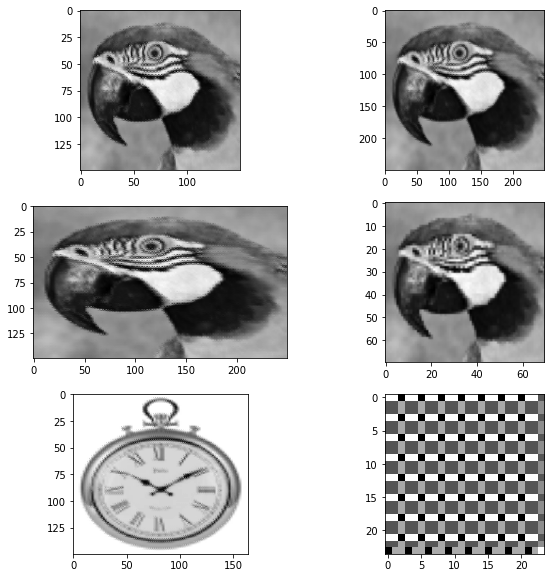

In [57]:
fig_bin_dwuliniowa, ([ax1, bx1], [ax2, bx2], [cx1, cx2]) = plt.subplots(3,2, figsize=(10,10))
ax1.imshow(binaryzacja_dwuliniowa(I, 1.5, 1.5))
bx1.imshow(binaryzacja_dwuliniowa(I, 2.5, 2.5))
ax2.imshow(binaryzacja_dwuliniowa(I, 1.5, 2.5))
bx2.imshow(binaryzacja_dwuliniowa(I, 0.7, 0.7))
cx1.imshow(binaryzacja_dwuliniowa(CLOCK, 1.5, 2))
cx2.imshow(binaryzacja_dwuliniowa(CHESS, 1.5, 1.5))

## Intepolacja w OpenCV

W OpenCV dostępna jest funkcja `resize`, która służy do zmiany rozmiaru obrazka.
Składnia jest następująca `dst = cv2.resize(	src, dsize[, dst[, fx[, fy[, interpolation]]]] )`, gdzie `det` to obraz wynikowy, `src` obraz źródłowy, `dsize` rozmiar docelowy (ew. można podać współczynniki skalowania dla poszczególnych osi: `fx,fy`), `interpolation` metoda interpolacji.
Metod podstawowych dostępnych jest 5:
- najbliższego sąsiada - ` cv2.INTER_NEAREST`,
- dwuliniowa - ` cv2.INTER_LINEAR`,
- dwukubiczna - ` cv2.INTER_CUBIC`,
- *area* - ` cv2.INTER_AREA`,
- *lanczos4* - ` cv2.INTER_LANCZOS4`.

Przeprowadzimy następujący eksperyment: obraz (o większej niż dotąd rozdzielczości) przeskalujemy każdą z metod -- zwiększymy i zmniejszymy jego rozdzielczość. Dodamy też pomiar czasu realizacji obliczeń.

Obraz: TODO


Proszę stworzyć funkcję, która jako argumenty przyjmuje obraz oraz dwa współczynniki skalujące, a wewnątrz przeprowadzone zostaną interpolacje, pomiar czasu oraz wizualizacja (można wypisać czas w tytule rysunku).

Pomiar czasu:
```{python}
from timeit import default_timer as timer
start = timer()
# ...
end = timer()
print(end - start)
```

Wykonaj eksperyment dla kilku różnych skal, przeanalizuj czasy obliczeń.

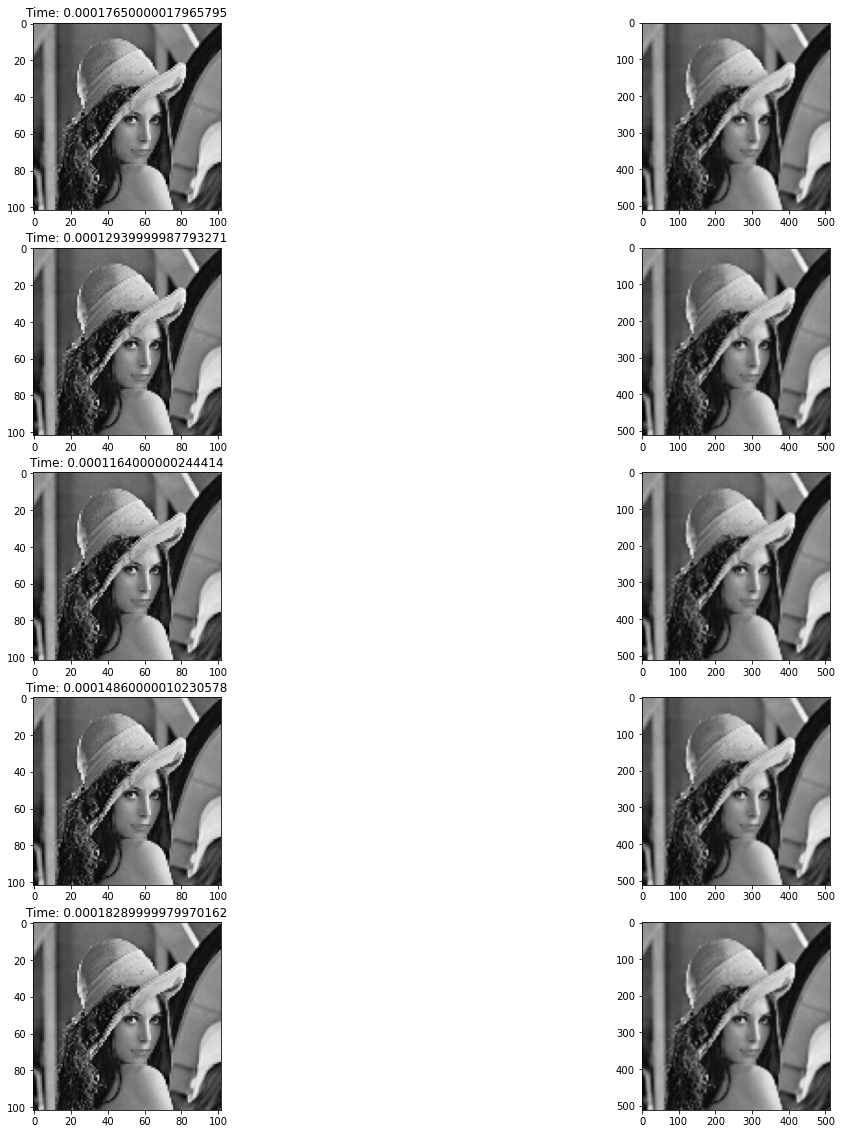

In [47]:
from timeit import default_timer as timer
LENA = cv2.imread('lena.bmp')           
LENA = cv2.cvtColor(LENA, cv2.COLOR_BGR2GRAY)

def interpolacja_test(img, s_x, s_y, type_):
    X, Y = img.shape
    start = timer()
    img_resized = cv2.resize(img,(int(s_x*Y), int(s_y*X)), type_)
    img_resized2 = cv2.resize(img_resized,(int(X),int(Y)), type_)
    end = timer()
    time = (end - start)
    return [img_resized, img_resized2, time]

f, ([ax1, ax2], [bx1, bx2], [cx1, cx2], [dx1, dx2], [ex1, ex2]) = plt.subplots(5,2, figsize=(20,20))
TAB1 = interpolacja_test(LENA, 0.2, 0.2, cv2.INTER_NEAREST)
TAB2 = interpolacja_test(LENA, 0.2, 0.2, cv2.INTER_LINEAR)
TAB3 = interpolacja_test(LENA, 0.2, 0.2, cv2.INTER_CUBIC)
TAB4 = interpolacja_test(LENA, 0.2, 0.2, cv2.INTER_AREA)
TAB5 = interpolacja_test(LENA, 0.2, 0.2, cv2.INTER_LANCZOS4)
ax1.imshow(TAB1[0])
ax1.set_title("Time: " + str(TAB1[2]))
ax2.imshow(TAB1[1])

bx1.imshow(TAB2[0])
bx1.set_title("Time: " + str(TAB2[2]))
bx2.imshow(TAB2[1])

cx1.imshow(TAB3[0])
cx1.set_title("Time: " + str(TAB3[2]))
cx2.imshow(TAB3[1])

dx1.imshow(TAB4[0])
dx1.set_title("Time: " + str(TAB4[2]))
dx2.imshow(TAB4[1])

ex1.imshow(TAB5[0])
ex1.set_title("Time: " + str(TAB5[2]))
ex2.imshow(TAB5[1])

    

## Rozdzielczość (dpi)

Omówioną wcześniej rozdzielczość przestrzenną (rozmiar) należy utożsamiać z rozmiarem macierzy w której zapisany jest obraz.
W tym ujęciu rozmiar pojedynczego piksela nie ma specjalnego znaczenia.
Problem pojawia się, kiedy obraz trzeba wyświetlić lub wydrukować.
Wtedy pojedynczy piksel staje się ,,obiektem fizycznym'' i musi mieć swój rozmiar (wysokość/szerokość/powierzchnię).

Parametr dpi (ang. *dots per inch*) określa liczbę kropek (pikseli), która mieści się na jednym calu (25,4 mm) długości/szerokości.
Dopiero kombinacja rozmiaru i rozdzielczości określa nam rzeczywisty rozmiar obrazu jaki uzyskamy na wydruku.

Dpi staje się istotne w przypadku drukowania, gdyż wyświetlanie na monitorze odbywa się zazwyczaj 1 piksel obrazka = 1 piksel na monitorze (w przypadku maksymalnej rozdzielczości wspieranej przez monitor), ew. następuje automatyczne skalowanie.

Wpływ rozdzielczości można zademonstrować w następujący sposób:
- wczytaj obraz *lena.bmp*.  Ma on rozmiar $512 \times 512$.
- wykorzystując funkcję `imresize` stwórz obrazy o rozmiarach $256 \times 256$, $128 \times 128$, $64 \times 64$ - metoda interpolacji jest w tym wypadku mniej istotna.
- wyświetl obrazy wymuszając zachowanie na ekranie wejściowej rozdzielczości $512 \times 512$. W przypadku biblioteki *matplotlib* ta funkcjonalność jest domyślna.

Proszę zaobserwować co dzieję się z obrazkiem.

<Figure size 432x288 with 0 Axes>

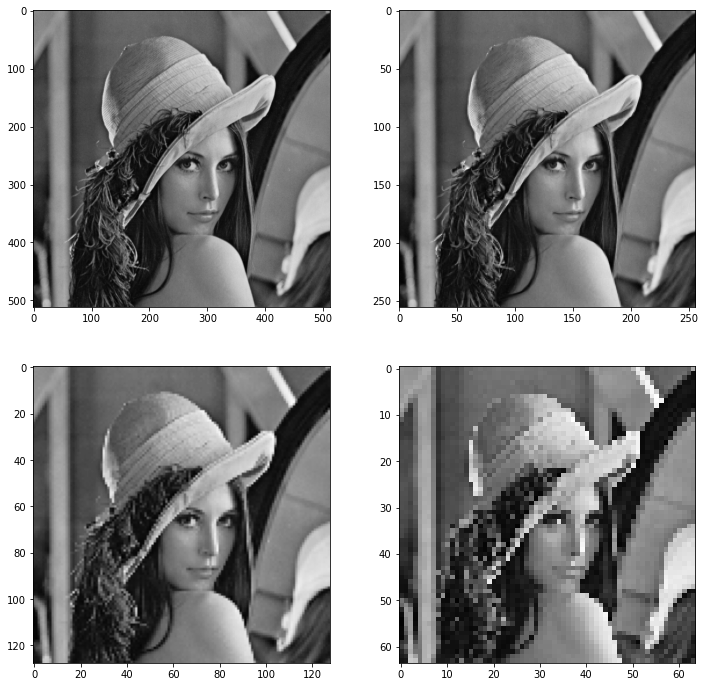

In [49]:
LENA = cv2.imread('lena.bmp')           
LENA = cv2.cvtColor(LENA, cv2.COLOR_BGR2GRAY)
plt.gray()
def resize_img(img, x_val, y_val):
    img_resized = cv2.resize(img,(int(x_val),int(y_val)))
    return img_resized

f, ([ax1, ax2], [bx1, bx2]) = plt.subplots(2,2, figsize=(12,12))
ax1.imshow(resize_img(LENA, 512, 512))
ax2.imshow(resize_img(LENA, 256, 256))
bx1.imshow(resize_img(LENA, 128, 128))
bx2.imshow(resize_img(LENA, 64, 64))

## Liczba poziomów jasności

Dla obrazów w skali szarości pojedynczy piksel zwykle zapisuje się na 8 bitach, co daje 256 rozróżnialnych poziomów szarości.
Dla większości zastosowań wartość ta jest wystarczająca (choć są kamery o wyjścu 12 lub 16 bitów).
Jednak oko ludzkie nie potrafi rozróżnić wszystkich 256 poziomów jasności (jest za mało czułe).
Zazwyczaj człowiek rozróżnia 20-30 poziomów szarości (to ile i jakie dokładnie rozróżnia, zależy od konkretnego oświetlenia sceny i cech osobniczych).

W poniższych krokach zademonstrujemy omówione zjawisko:
- wczytaj (użyj) obrazu _lena_,
- wykorzystując znaną funkcję `normalize` zmień liczbę poziomów szarości z 0-255 na:
    * 0-31
    * 0-15
    * 0-7
    * 0-3
    * 0-1 (binaryzacja)
- rezultaty wyświetl na wspólnym rysunku.

Podpowiedzi:
- trzeba przygotować tablice na obrazki np, `I_31 = np.zeros(I.shape,'uint8')`,
- prawidłowe użycie funkcji normalize `cv2.normalize(I,I_31,0,31,cv2.NORM_MINMAX)`,
- przykładowe wyświetlanie `axsHist[0,1].imshow(I, 'gray', vmin=0, vmax=31)`.

Czy rezultaty eksperymentu pasują do teorii o rozpoznawaniu przez człowieka ograniczonego zakresu poziomów jasności?
Wizualne porównanie których obrazów o tym świadczy ?

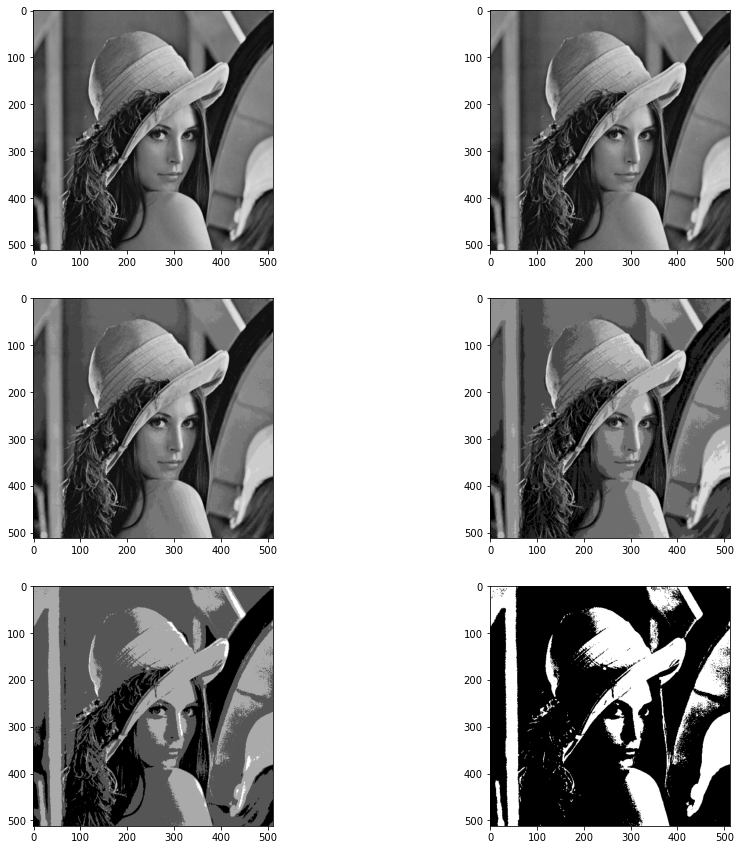

In [50]:
def poziomy_jasnosci(img, l, r):
    I_TAB = np.zeros(img.shape,'uint8')
    
    IMG_NORMALIZED = cv2.normalize(img,I_TAB,l,r,cv2.NORM_MINMAX)
    
    return IMG_NORMALIZED

LENA = cv2.imread('lena.bmp')           
LENA = cv2.cvtColor(LENA, cv2.COLOR_BGR2GRAY)
f, ([ax1, ax2], [bx1, bx2], [cx1, cx2]) = plt.subplots(3,2,figsize=(15,15))

ax1.imshow(poziomy_jasnosci(LENA, 0, 255),'gray', vmin=0, vmax=255)
ax2.imshow(poziomy_jasnosci(LENA, 0, 31),'gray', vmin=0, vmax=31)
bx1.imshow(poziomy_jasnosci(LENA, 0, 15),'gray', vmin=0, vmax=15)
bx2.imshow(poziomy_jasnosci(LENA, 0, 7),'gray', vmin=0, vmax=7)
cx1.imshow(poziomy_jasnosci(LENA, 0, 3),'gray', vmin=0, vmax=3)
cx2.imshow(poziomy_jasnosci(LENA, 0, 1),'gray', vmin=0, vmax=1)


# Zadanie domowe -- interpolacja dwusześcienna

Interpolacja dwusześcienna, to podobnie jak w przypadku interpolacji dwuliniowej, rozszerzenie idei interpolacji jednowymiarowej na dwuwymiarową siatkę.
W trakcie jej obliczania wykorzystywane jest 16 pikseli z otoczenia (dla dwuliniowej 4).
Skutkuje to zwykle lepszymi wynikami - obraz wyjściowy jest bardziej gładki i z mniejszą liczbą artefaktów.
Ceną jest znaczny wzrost złożoności obliczeniowej (zostało to zaobserwowane podczas ćwiczenia).

Interpolacja dana jest wzorem:
\begin{equation}
I(i,j) = \sum_{i=0}^{3} \sum_{j=0}^{3} a_{ij} x^i y^j
\end{equation}

Zadanie sprowadza się zatem do wyznaczenia 16 współczynników $a_{ij}$.
W tym celu wykorzystuje się, oprócz wartość w~puntach $A$ (0,0), $B$ (1 0), $C$ (1,1), $D$ (0,1) (por. rysunek dotyczący interpolacji dwuliniowej), także pochodne cząstkowe $A_x$, $A_y$, $A_{xy}$.
Pozwala to rozwiązać układ 16-tu równań.

Jeśli zgrupujemy parametry $a_{ij}$:
\begin{equation}
a = [ a_{00}~a_{10}~a_{20}~a_{30}~a_{01}~a_{11}~a_{21}~a_{31}~a_{02}~a_{12}~a_{22}~a_{32}~a_{03}~a_{13}~a_{23}~a_{33}]
\end{equation}

i przyjmiemy:
\begin{equation}
x = [A~B~D~C~A_x~B_x~D_x~C_x~A_y~B_y~D_y~C_y~A_{xy}~B_{xy}~D_{xy}~C_{xy}]^T
\end{equation}

To zagadnienie można opisać w postaci równania liniowego:
\begin{equation}
Aa = x
\end{equation}
gdzie macierz $A^{-1}$ dana jest wzorem:

\begin{equation}
A^{-1} =
\begin{bmatrix}
1& 0& 0& 0& 0& 0& 0& 0& 0& 0& 0& 0& 0& 0& 0& 0 \\
0&  0&  0&  0&  1&  0&  0&  0&  0&  0&  0&  0&  0&  0&  0&  0 \\
-3&  3&  0&  0& -2& -1&  0&  0&  0&  0&  0&  0&  0&  0&  0&  0 \\
2& -2&  0&  0&  1&  1&  0&  0&  0&  0&  0&  0&  0&  0&  0&  0 \\
0&  0&  0&  0&  0&  0&  0&  0&  1&  0&  0&  0&  0&  0&  0&  0 \\
0&  0&  0&  0&  0&  0&  0&  0&  0&  0&  0&  0&  1&  0&  0&  0 \\
0&  0&  0&  0&  0&  0&  0&  0& -3&  3&  0&  0& -2& -1&  0&  0 \\
0&  0&  0&  0&  0&  0&  0&  0&  2& -2&  0&  0&  1&  1&  0&  0 \\
-3&  0&  3&  0&  0&  0&  0&  0& -2&  0& -1&  0&  0&  0&  0&  0 \\
0&  0&  0&  0& -3&  0&  3&  0&  0&  0&  0&  0& -2&  0& -1&  0 \\
9& -9& -9&  9&  6&  3& -6& -3&  6& -6&  3& -3&  4&  2&  2&  1 \\
-6&  6&  6& -6& -3& -3&  3&  3& -4&  4& -2&  2& -2& -2& -1& -1 \\
2&  0& -2&  0&  0&  0&  0&  0&  1&  0&  1&  0&  0&  0&  0&  0 \\
0&  0&  0&  0&  2&  0& -2&  0&  0&  0&  0&  0&  1&  0&  1&  0 \\
-6&  6&  6& -6& -4& -2&  4&  2& -3&  3& -3&  3& -2& -1& -2& -1 \\
4& -4& -4&  4&  2&  2& -2& -2&  2& -2&  2& -2&  1&  1&  1&  1 \\
\end{bmatrix}
\end{equation}

Potrzebne w rozważaniach pochodne cząstkowe obliczane są wg. następującego przybliżenia (przykład dla punktu A):
\begin{equation}
A_x = \frac{I(i+1,j) - I(i-1,j)}{2}
\end{equation}
\begin{equation}
A_y = \frac{I(i,j+1) - I(i,j-1)}{2}
\end{equation}
\begin{equation}
A_xy = \frac{I(i+1,j+1) - I(i-1,j) - I(i,j-1) + I(i,j)}{4}
\end{equation}

## Zadanie

Wykorzystując podane informacje zaimplementuj interpolację dwusześcienną.
Uwagi:
- macierz $A^{-1}$ dostępna jest w pliku *a_invert.py*
- trzeba się zastanowić nad potencjalnym wykraczaniem poza zakres obrazka (jak zwykle).

Ponadto dokonaj porównania liczby operacji arytmetycznych i~dostępów do pamięci koniecznych przy realizacji obu metod interpolacji: dwuliniowej i~dwusześciennej.

In [ ]:
#TODO Do samodzielnej implementacji
